In [36]:
from mpl_toolkits import mplot3d
import cv2 as cv
import numpy as np
import scipy.linalg as la
import scipy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Simple image displaying

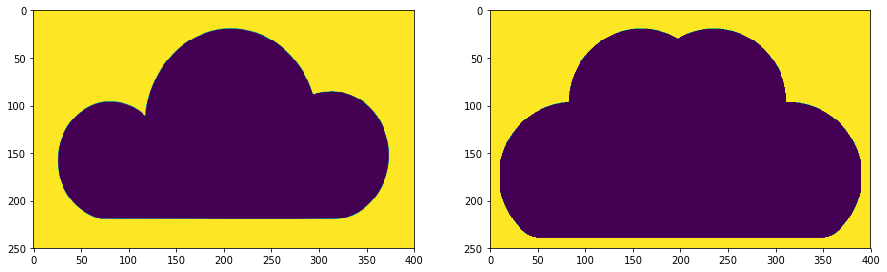

In [37]:
w = 400
h = 250

cloud_1_raw = cv.imread("Images/cloud_1.png")
cloud_2_raw = cv.imread("Images/cloud_2.png")
cloud_1_raw = cv.resize(cloud_1, (w, h))
cloud_2_raw = cv.resize(cloud_2, (w, h))

R = np.zeros((h, w))
T = np.zeros((h, w))

# Convert images to normalized 2D numpy arrays
for i in range(h):
    for j in range(w):
        R[i][j] = sum(cloud_1_raw[i][j]) / 765
        T[i][j] = sum(cloud_2_raw[i][j]) / 765

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(R)
plt.subplot(1, 2, 2)
plt.imshow(T)

# Function definitions

In [44]:
grid_x, grid_y = np.mgrid[0:h:10*h, 0:w:10*w] # Grid over which we want to interpolate
points = np.array([[i % w, i // w] for i in range(w * h)]) #Array of where pixels are known
R_interp = griddata(points, np.ndarray.flatten(R), (grid_x, grid_y), method='cubic')

(250, 400)


ValueError: setting an array element with a sequence.

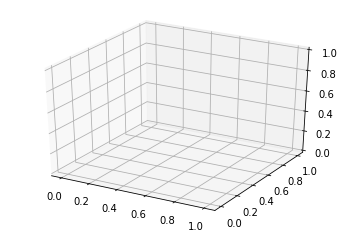

In [42]:
fig = plt.figure()
X = np.arange(w)
Y = np.arange(h)
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, R_interp, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');